# DC Resistivity Part 1

**Author:** [Lindsey Heagy](https://github.com/lheagy)

This example examines a model similar to that analyzed in [Kaufman (1990)](https://doi.org/10.1190/1.1442769). This notebook was used to produce Figure 5 in Heagy and Oldenburg (2018)

If you encounter problems when running this notebook, please [open an issue](https://github.com/simpeg-research/heagy_2018_emcyl/issues). 

## Setup and Software environment

The requirements to run this example are in [requirements.txt](../requirements.txt). Uncomment the following cell if you need to install them. 

In [1]:
# !pip install -r ../requirements.txt

In [2]:
import discretize
from discretize import utils
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.constants import mu_0
import ipywidgets

from SimPEG.EM import TDEM
from SimPEG import Utils, Maps

import casingSimulations as casingSim

from pymatsolver import Pardiso

%matplotlib inline

In [3]:
from matplotlib import rcParams
rcParams['font.size'] = 14

##  Simulation Parameters

Here, we set a simulation directory where we can save the results and set the other main parameters for the example including the casing length and the conductivity of the background

In [4]:
simDir = 'DC_Kaufman'  # create a simulation directory where results can be saved. 

In [5]:
# casing parameters by experiment 
casing_l=2000 # 2km long casing
casing_t = 10e-3 # 10mm thick casing
casing_d = 100e-3 # 10cm diameter

sigma_back=1e-2 # 100 Ohm-background
sigma_casing=1e6  # conductivity of the casing

In [6]:
print(
    'The casing is {}m long, and the '
    'conductivity of the background is {} S/m'.format(
        casing_l, sigma_back
    )
)

The casing is 2000m long, and the conductivity of the background is 0.01 S/m


In [7]:
model = casingSim.model.CasingInWholespace(
    directory = simDir,
    sigma_casing = sigma_casing,  # conductivity of the casing (S/m)
    sigma_back = sigma_back,  # conductivity of the background (S/m)
    sigma_inside = sigma_back,  # fluid inside the well has same conductivity as the background
    casing_d = casing_d-casing_t,  # 10c.m is outer casing diameter
    casing_l = casing_l,
    casing_t = casing_t, 
    src_a = np.r_[0., 0., -casing_l/2.],  # put the A electrode just below the surface
    src_b = np.r_[2*casing_l, 0., -casing_l/2.] # put the return electrode at a distance of 2 x length of well away
)

In [8]:
# Here we print the parameters being used to set up the simulation
model.serialize()

{u'__class__': 'CasingInWholespace',
 'casing_d': 0.09000000000000001,
 'casing_l': 2000.0,
 'casing_t': 0.01,
 'casing_top': 0.0,
 'directory': u'DC_Kaufman',
 'filename': u'ModelParameters.json',
 'mur_back': 1.0,
 'mur_casing': 1.0,
 'sigma_back': 0.01,
 'sigma_casing': 1000000.0,
 'sigma_inside': 0.01,
 'src_a': [0.0, 0.0, -1000.0],
 'src_b': [4000.0, 0.0, -1000.0],
 'version': u'0.0.5'}

In [9]:
# copy the model and set the conductivity equal to the background so we have a baseline response to compare to
wholespace = model.copy()
wholespace.sigma_casing = wholespace.sigma_back

## Mesh

Here we set up a 3D cylindrical mesh, discretizing in $x$, $\theta$ and $z$. 

To discretize in x, we start by defining the finest region of the mesh, ensuring that we have 4 cells across the thickness of the casing. From there, we expand the cell sizes until we reach the second uniform cell size we want to model at (`csx2`). We then use a constant cell spacing of `csx2` until we have meshed out to the end of the domain in which we want to examine data (`domainx2`). Beyond that, we add padding cells to *"infinity"*

In [10]:
# parameters defining the core region of the mesh
# note that the finest re
csx2 = 25.  # cell size in the x-direction in the second uniform region of the mesh (where we measure data)
csz = 0.1  # cell size in the z-direction 
domainx2 = 100  # go out 500m from the well

# padding parameters
npadx, npadz = 15, 29  # number of padding cells
pfx2 = 1.4  # expansion factor for the padding to infinity in the x-direction
pfz = 1.4

# set up a mesh generator which will build a mesh based on the provided parameters
# and casing geometry
cylMeshGen = casingSim.CasingMeshGenerator(
    directory=simDir,  # directory where we can save things
    modelParameters=model,  # casing parameters
    npadx=npadx,  # number of padding cells in the x-direction
    npadz=npadz,  # number of padding cells in the z-direction
    domain_x=domainx2,  # extent of the second uniform region of the mesh 
#     hy=0,   # cell spacings in the 
    csx1=model.casing_t/4.,  # use at least 4 cells per across the thickness of the casing
    csx2=csx2,  # second core cell size
    csz=csz,  # cell size in the z-direction
    pfx2=pfx2,  # padding factor to "infinity"
    pfz=pfz  # padding factor to "infinity" for the z-direction
)

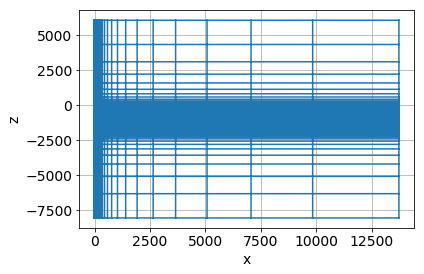

In [11]:
cylMeshGen.mesh.plotGrid()

## Put the physical properties on the mesh

Organize models in a dictionary

In [12]:
# put the models in a dictionary for convienence 
model_names = ['background', 'casing']
modelDict = dict(zip(model_names, [wholespace, model]))

In [13]:
# Assign physical properties on the mesh
physpropsDict = {
    name: casingSim.model.PhysicalProperties(cylMeshGen, mod) 
    for name, mod in modelDict.iteritems()
}

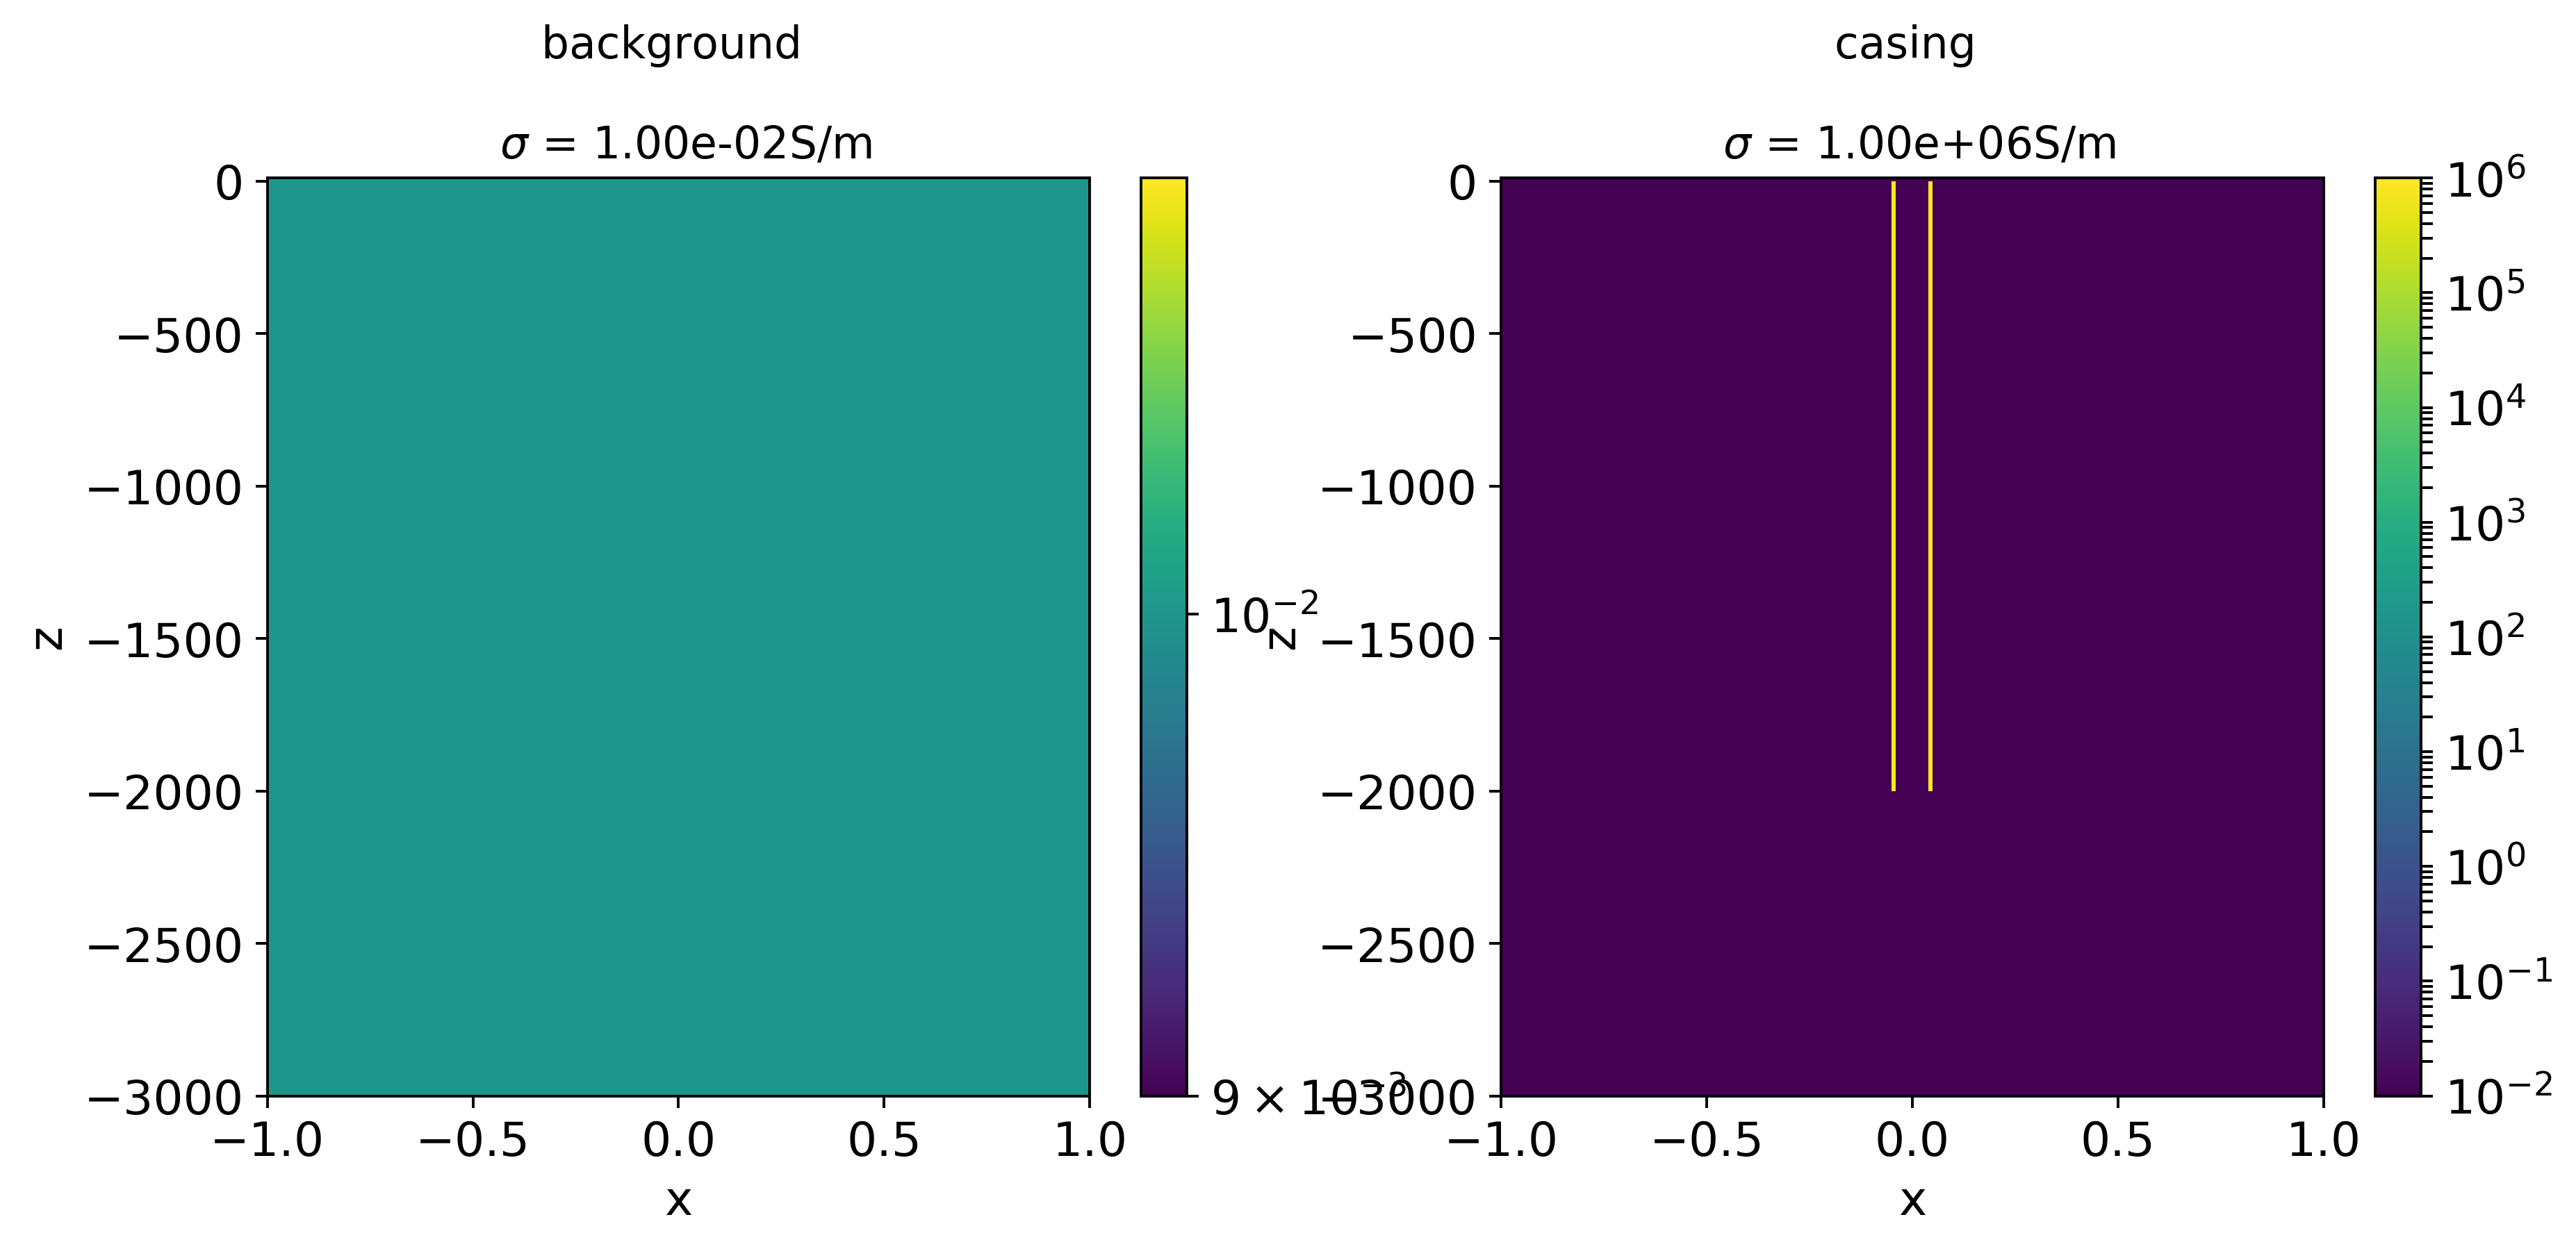

In [14]:
# Plot the models
xlim = np.r_[-1, 1]  # x-limits in meters
zlim = np.r_[-1.5*model.casing_l, 10.]  # z-limits in meters. (z-positive up)

fig, ax = plt.subplots(1, len(model_names), figsize=(6*len(model_names), 5), dpi=350)
if len(model_names) == 1:
    ax = [ax]
    
for a, title in zip(ax, model_names):
    pp = physpropsDict[title]
    pp.plot_sigma(
        ax=a, 
        pcolorOpts={'norm':LogNorm()}  # plot on a log-scale
    )
    a.set_title('{} \n\n $\sigma$ = {:1.2e}S/m'.format(title, pp.modelParameters.sigma_casing), fontsize=13)
#     cylMeshGen.mesh.plotGrid(ax=a, slice='theta') # uncomment to plot the mesh on top of this
    a.set_xlim(xlim)
    a.set_ylim(zlim)

Text(0.055,-1000,u'source')

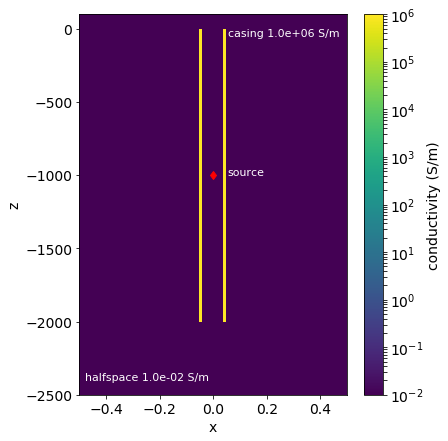

In [15]:
# Plot the source location

symbols = ['rd', 'ws', 'k>', 'mo', 'c*', 'C3s']

fig, ax = plt.subplots(1, 1, figsize=(6, 7))

# cylMeshGen.mesh.plotGrid(ax=ax, slice='theta')
ax, cb = physpropsDict['casing'].plot_sigma(
    ax=ax, 
    pcolorOpts={'norm':LogNorm()}  # plot on a log-scale
)

cb.set_label('conductivity (S/m)')

ax.set_title('')

ax.plot(model.src_a[0], model.src_a[2], symbols[0])
ax.plot(model.src_b[0], model.src_b[2], symbols[0])
    
ax.set_xlim(0.5*np.r_[-1, 1]) #src_b[:, 0].max()])
ax.set_ylim([ -1.25*model.casing_l, 100])

xtext = -0.48
# ax.annotate('air {:1.1e} S/m'.format(model.sigma_air), xy=(xtext, 10), color='w', fontsize=11)
ax.annotate('casing {:1.1e} S/m'.format(model.sigma_casing), xy=(0.055, -50), color='w', fontsize=11)
ax.annotate('halfspace {:1.1e} S/m'.format(model.sigma_back), xy=(xtext, -1.2*model.casing_l), color='w', fontsize=11)
ax.annotate(
    'source', xy=(0.055, model.src_a[2]), color='w', fontsize=11, 
)



## set up a DC simulation

In [16]:
simDict = {}
for title in model_names:
    simDict[title] = casingSim.run.SimulationDC(
        modelParameters=modelDict[title], directory=simDir, 
        meshGenerator=cylMeshGen, 
        src_a=modelDict[title].src_a, src_b=modelDict[title].src_b
    )


Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.


## run the DC simulation

In [17]:
%%time
fieldsDict = {}
for title in model_names:
    print('--- Running {} ---'.format(title))
    fieldsDict[title] = simDict[title].run()
    print('\n')

--- Running background ---
Validating parameters...
      max x: 13724.7083613, min z: -8050.50808887, max z: 6050.50808888, nC: 1525168
Saved DC_Kaufman/simulationParameters.json
Starting SimulationDC
Using <class 'pymatsolver.direct.Pardiso'> Solver
   ... Done. Elapsed time : 11.4668951035


--- Running casing ---
Validating parameters...
      max x: 13724.7083613, min z: -8050.50808887, max z: 6050.50808888, nC: 1525168
Saved DC_Kaufman/simulationParameters.json
Starting SimulationDC
Using <class 'pymatsolver.direct.Pardiso'> Solver
   ... Done. Elapsed time : 11.2855491638


CPU times: user 25.1 s, sys: 4.14 s, total: 29.2 s
Wall time: 22.8 s


## Plotting code: Fields, Fluxes, and Charges

In [18]:
# Plot the charges
mesh2D = cylMeshGen.create_2D_mesh().mesh
src_ind=0
theta_ind=0
background_key = 'background'

def plotCasingResults(
    ax = None,
    clim_max=None, clim_min=None, 
    max_depth=1.1*model.casing_l, 
    max_r=0.1, top=10., view='charge', model='casing', 
    primsec=['total', 'primary', 'secondary'], 
    casing_outline=True, cb_extend=None
):
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(5, 6))
        
    assert view.lower() in ['charge', 'phi', 'j', 'e']

    xlim = max_r*np.r_[-1, 1]  # x-limits in meters
    zlim = np.r_[-max_depth, top]  # z-limits in meters. (z-positive up)
    
    clim = None
    plotopts = {
        'theta_ind': theta_ind,
    }
    
    if not clim_max is not None or clim_max != 0.:
        clim = clim_max * np.r_[-1 if view in ['charge', 'phi'] else 0, 1]
#         plotopts['clim'] = clim

        if clim_min is not None or clim_min != 0.:
            clim[0] = clim_min
        
    if primsec == 'primary':
        model = background_key

    pp = physpropsDict[model]
    src = simDict[model].survey.srcList[src_ind]
    plotme = simDict[model].fields()[src, view]
    
    if primsec == 'secondary':
        prim_src = simDict[background_key].survey.srcList[src_ind]
        plotme = plotme - simDict[background_key].fields()[prim_src, view]

    if view in ['charge', 'phi']:
        out = pp.plot_prop(
            plotme,
            ax=ax,
            pcolorOpts = {
                'cmap': 'bwr' if view == 'charge' else 'viridis', 
            },
            cb_extend=cb_extend,
            clim=clim,
            **plotopts 
        )
    elif view in ['j', 'e']:
        jplt = casingSim.face3DthetaSlice(
            cylMeshGen.mesh, plotme, theta_ind=theta_ind
        )
        out = casingSim.plotFace2D(
            mesh2D,
            jplt, real_or_imag='real', ax=ax, range_x=xlim,
            range_y=zlim, sample_grid=np.r_[np.diff(xlim)/100., np.diff(zlim)/100.],
            logScale=True, clim=clim, mirror=True, 
        )
        
    if clim is not None:
        cb = out[-1]
        cb.set_clim(clim)
        cb.update_ticks()
    ax.set_title('{} {}'.format(primsec, view), fontsize=13)
    #     cylMeshGen.mesh.plotGrid(ax=a, slice='theta') # uncomment to plot the mesh on top of this
    ax.set_xlim(xlim)
    ax.set_ylim(zlim)
#         cb.set_label(view)
        
    # plot outline of casing
    if casing_outline is True: 
        m = modelDict[model]
        factor = [-1, 1]
        [
            ax.plot(
                fact * np.r_[m.casing_a, m.casing_a, m.casing_b, m.casing_b, m.casing_a],
                np.r_[m.casing_z[1], m.casing_z[0], m.casing_z[0], m.casing_z[1], m.casing_z[1]],
                'k', 
                lw = 0.5
            ) 
            for fact in factor
        ]
    return out 
    

def plotCasingResultsWidget(
    clim_max=None, clim_min=None, 
    max_depth=1.1*model.casing_l, 
    max_r=0.1, top=10., view='charge', model='all', 
    primsec=['total', 'primary', 'secondary']
):
    
    model_names = model_names if model == 'all' else [model]
    
    fig, ax = plt.subplots(1, len(model_names), figsize=(len(model_names)*5, 6))
    if len(model_names) == 1:
        ax = [ax]
    
    for a, mod in zip(ax, model_names): 
        a = plotCasingResults(
            ax = a,
            clim_max=clim_max, clim_min=clim_min, 
            max_depth=max_depth, 
            max_r=max_r, top=top, view=view, model=mod, 
            primsec=primsec, 
            casing_outline=True
        )
    
    plt.tight_layout()
    plt.show()

### Widget for viewing Results

The widgets available to you are
- **clim_max**: max value on the colorbar so you can saturate it
- **max_depth**: max z-limit for the plot
- **top**: top of the plot (z)

In [19]:
# fig, ax = plt.subplots(1, 3, figsize=(18, 5), dpi=350)

ipywidgets.interact(
    plotCasingResultsWidget,
    clim_max = ipywidgets.FloatText(value=0),
    clim_min = ipywidgets.FloatText(value=0),
    max_depth = ipywidgets.FloatText(value=1002), 
    max_r = ipywidgets.FloatText(value=0.1),
    top = ipywidgets.FloatText(value=-998),
    view = ipywidgets.ToggleButtons(
        options=['charge', 'phi', 'j', 'e'], value='j'
    ),
    model = ipywidgets.ToggleButtons(
        options=model_names + ['all'], value='casing'
    ),
    primsec = ipywidgets.ToggleButtons(
        options=['total', 'primary', 'secondary'], value='total'
    )
)   

<function __main__.plotCasingResultsWidget>

## Figure 5 in the paper

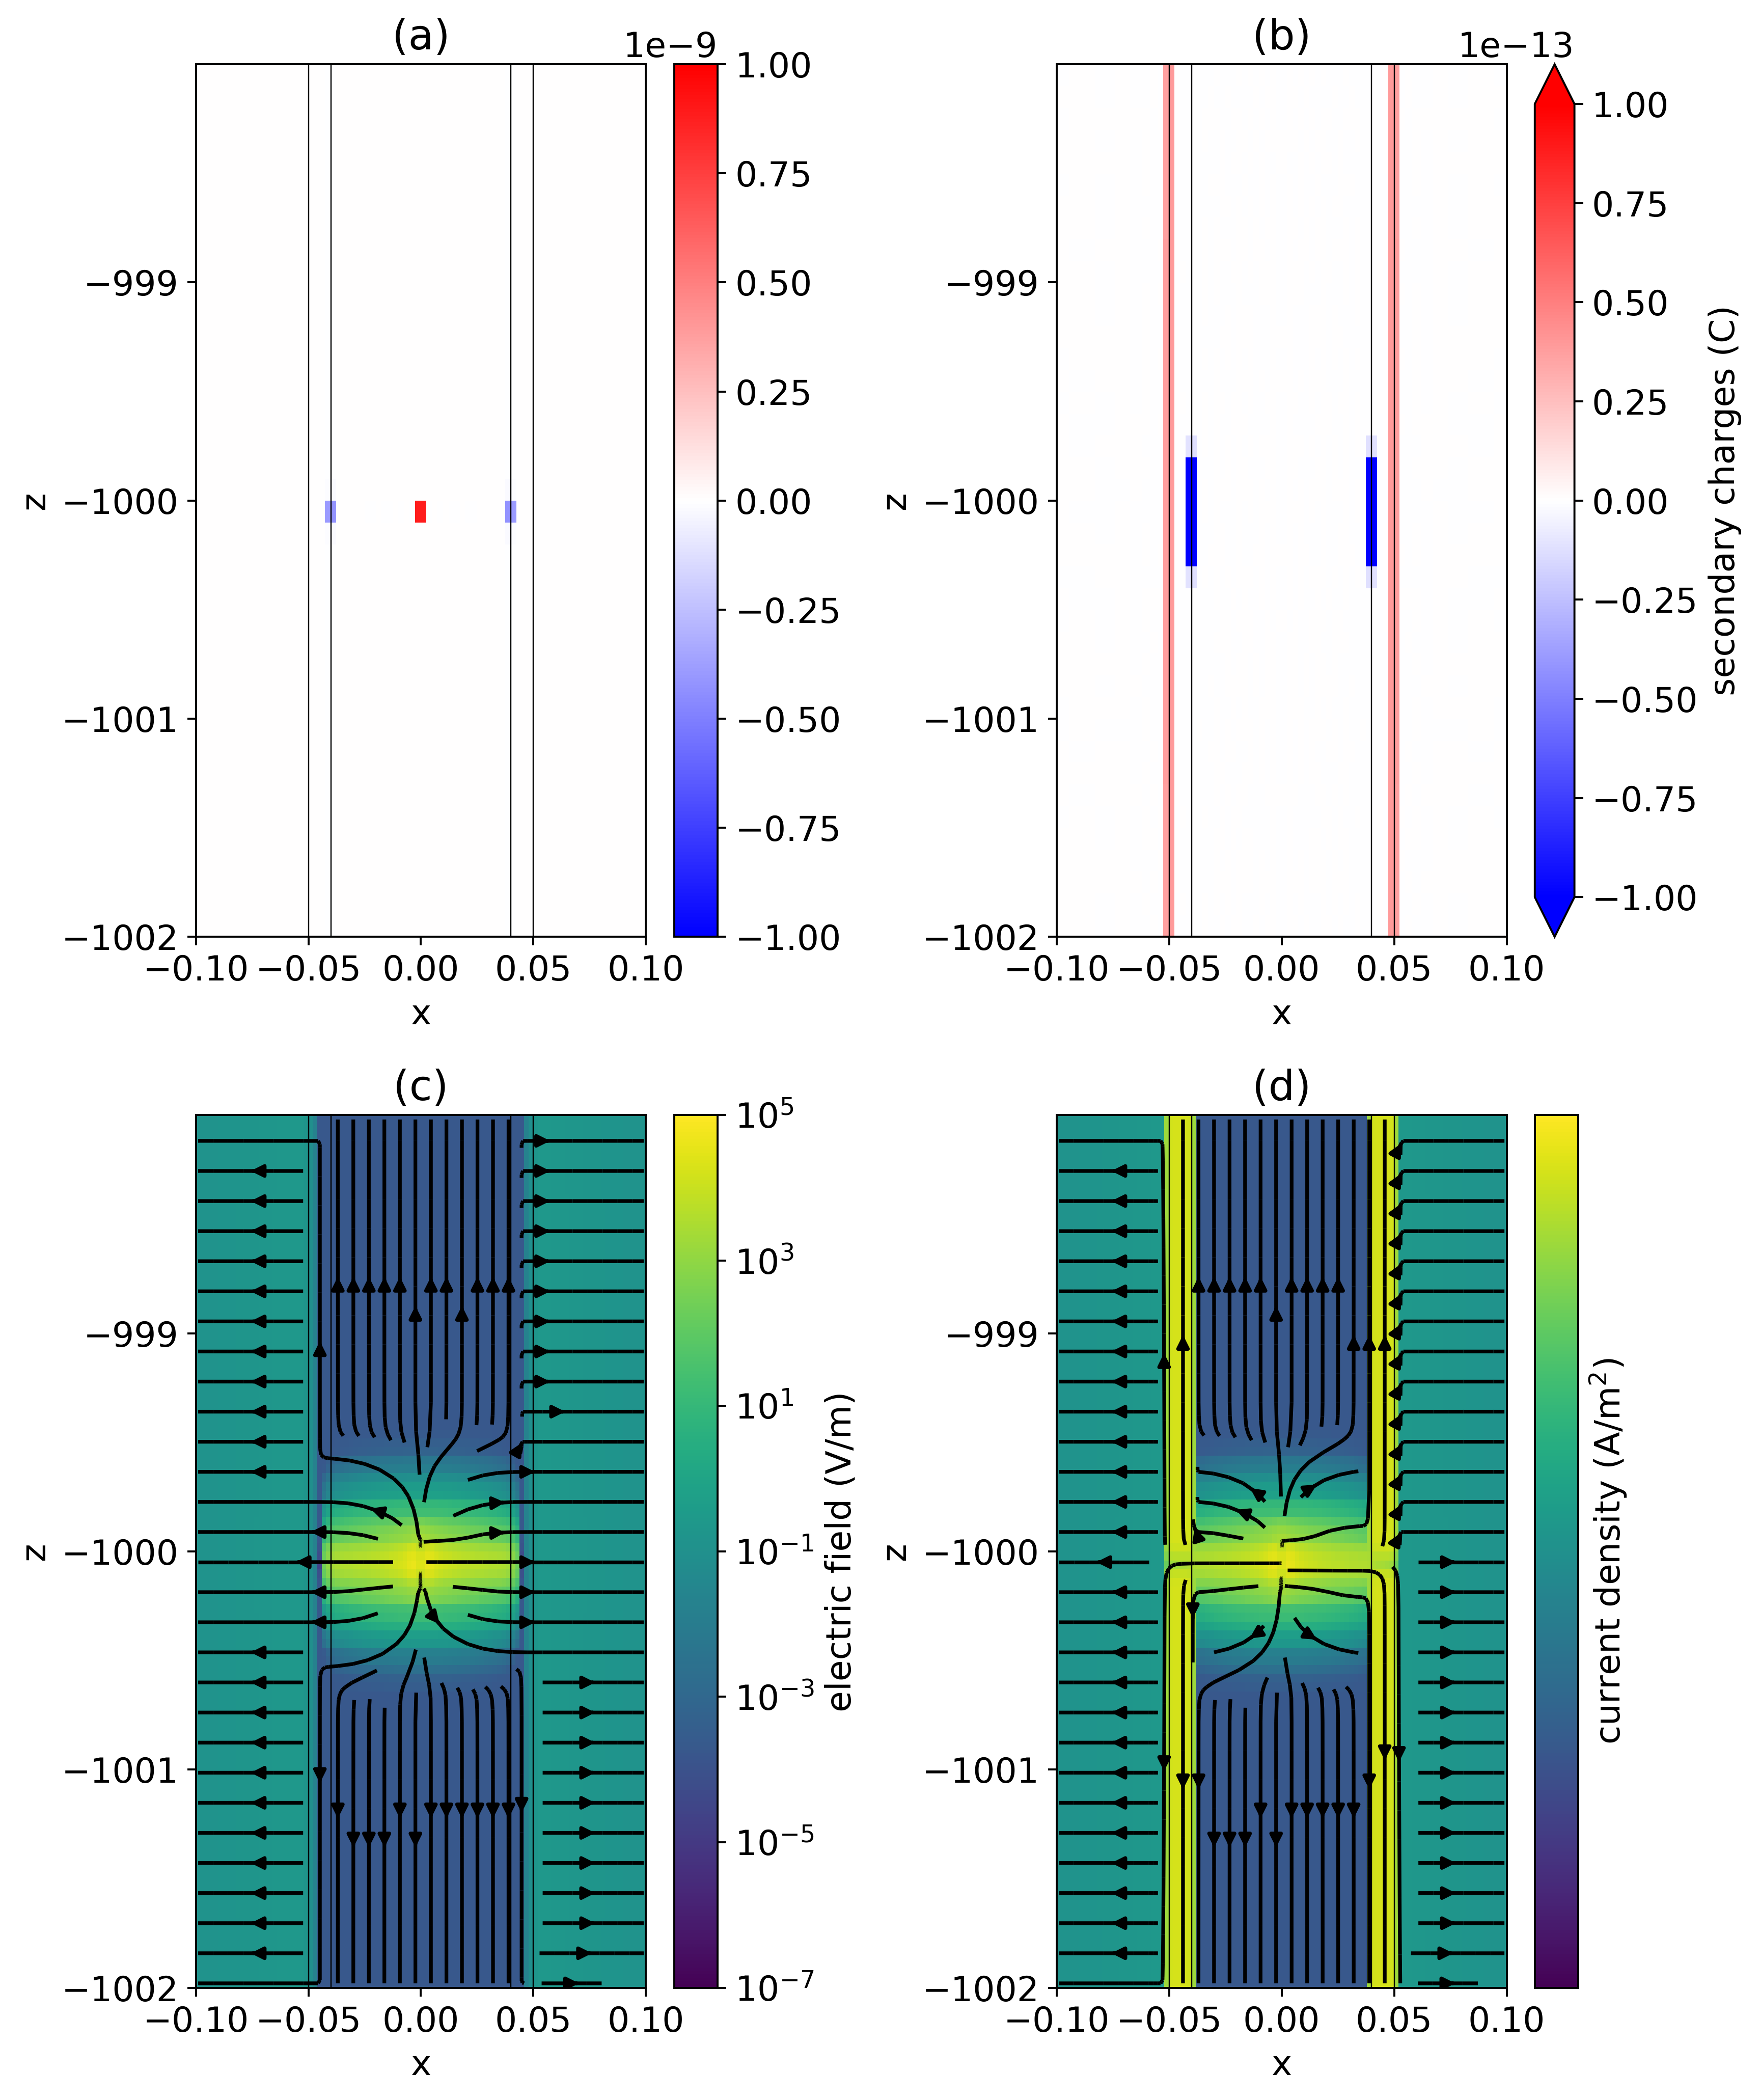

In [20]:
fig, ax = plt.subplots(2, 2, figsize=(2*5, 2*6), dpi=350)
ax=ax.flatten()

max_r = 0.1
top = -998
max_depth = 1002

# total charges
clim = 1e-9* np.r_[-1, 1]
out = plotCasingResults(
    ax = ax[0],
    clim_max=clim[1], clim_min=clim[0], 
    max_depth=max_depth, 
    max_r=max_r, top=top, view='charge', model='casing', 
    casing_outline=True
)
ax[0].set_title('(a)')
ax[0].set_yticks
cb.set_label('charges (C)')
# cb.set_clim(clim)

# charges
clim = 1e-13 * np.r_[-1, 1]
out = plotCasingResults(
    ax = ax[1],
    clim_max=clim[1], clim_min=clim[0], 
    max_depth=max_depth, 
    max_r=max_r, top=top, view='charge', model='casing',
    primsec='secondary',
    casing_outline=True,
    cb_extend='both'
)
ax[1].set_title('(b)')
out[-1].set_label('secondary charges (C)')

# electric field
clim = np.r_[1e-7, 1e5]
out = plotCasingResults(
    ax = ax[2],
    clim_max=clim[1], clim_min=clim[0], 
    max_depth=max_depth, 
    max_r=max_r, top=top, view='e', model='casing',
    casing_outline=True,
    cb_extend='both'
)
ax[2].set_title('(c)')
out[-1].set_label('electric field (V/m)')

# current density
clim = np.r_[1e-9, 1e3]
out = plotCasingResults(
    ax = ax[3],
    clim_max=clim[1], clim_min=clim[0], 
    max_depth=max_depth, 
    max_r=max_r, top=top, view='j', model='casing',
    casing_outline=True,
    cb_extend='both'
)
ax[3].set_title('(d)')
out[-1].set_label('current density (A/m$^2$)')


[a.set_yticks(np.arange(-max_depth, top)) for a in ax]

plt.tight_layout()



Uncomment to save the figure

In [21]:
# fig.savefig('kaufman_zones')